In [1]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor, DMatrix

In [2]:
#python package version information
print('Python version:{}'.format(sys.version))
print('Numpy version:{}'.format(np.__version__))
print('Pandas version:{}'.format(pd.__version__))
print('MatlpotLib version:{}'.format(matplotlib.__version__))
print('Seaborn version:{}'.format(sns.__version__))
print('Sci-Kit Learn version:{}'.format(sklearn.__version__))
print('XGBoost version:{}'.format(xgboost.__version__))

Python version:3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]
Numpy version:1.16.3
Pandas version:0.23.4
MatlpotLib version:3.0.3
Seaborn version:0.9.0
Sci-Kit Learn version:0.20.3
XGBoost version:0.82


In [3]:
eu = pd.read_csv('../input/eurusd-daily/eu.csv', index_col=0, parse_dates=True, skipinitialspace=True)
eu.drop('date', axis='columns', inplace=True)
eu.head(2)

,open,high,low,close,volume
1971-01-04,0.5369,0.5369,0.5369,0.5369,1
1971-01-05,0.5366,0.5366,0.5366,0.5366,1


In [4]:
eu.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

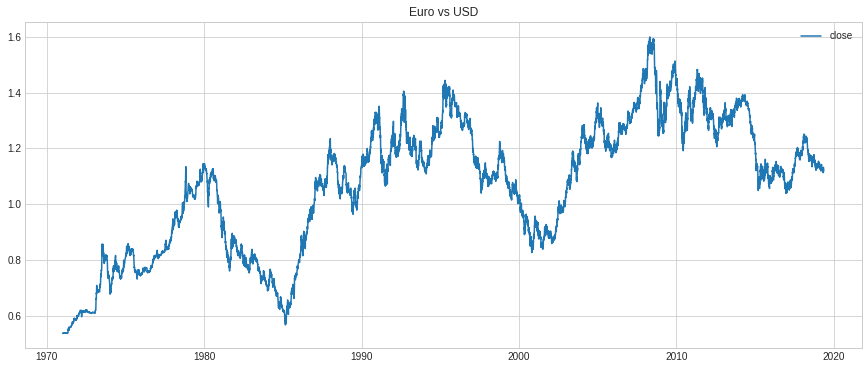

In [5]:
plt.figure(figsize=(15,6))
plt.plot(eu.close)
plt.title('Euro vs USD')
plt.legend()
plt.show()

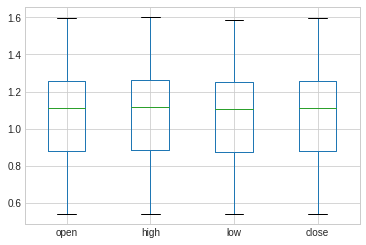

In [6]:
#box plot for open, high, low , close
eu.drop('volume', axis=1).boxplot()

In [7]:
#removing outliers above
vol_cut_off = eu.volume.std()*3 + eu.volume.mean()
eu.volume[eu.volume > vol_cut_off] = vol_cut_off

In [8]:
#removing ouliers below
vol_cut_off =  eu.volume.mean() - eu.volume.std()*3
eu.volume[eu.volume < vol_cut_off] = vol_cut_off

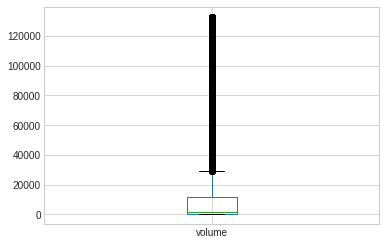

In [9]:
#boxplot for volume
eu[['volume']].boxplot()

In [10]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    df_new['volume_1'] = df['volume'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_905_'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']                                            
    
    
    # average volume
    df_new['avg_volume_5'] = df['volume'].rolling(window=5).mean().shift(1)
    df_new['avg_volume_30'] = df['volume'].rolling(window=21).mean().shift(1)
    df_new['avg_volume_90'] = df['volume'].rolling(window=63).mean().shift(1)
    df_new['avg_volume_365'] = df['volume'].rolling(window=252).mean().shift(1)
    
    #average volume ratio
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volumee_5_90'] = df_new['avg_volume_5'] / df_new['avg_volume_90']                                                   
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_90'] = df_new['avg_volume_30'] / df_new['avg_volume_90']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_90_365'] = df_new['avg_volume_90'] / df_new['avg_volume_365']                                                 
    
    
    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['close'].rolling(window=63).std().shift(1)                                               
    df_new['std_price_365'] = df['close'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90'] 
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']                                               
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']                                                
    
    
    # standard deviation of volumes
    df_new['std_volume_5'] = df['volume'].rolling(window=5).std().shift(1)
    df_new['std_volume_30'] = df['volume'].rolling(window=21).std().shift(1)
    df_new['std_volume_90'] = df['volume'].rolling(window=63).std().shift(1)
    df_new['std_volume_365'] = df['volume'].rolling(window=252).std().shift(1)
    
    #standard deviation ratio of volumes
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_90'] = df_new['std_volume_5'] / df_new['std_volume_90']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']                                               
    df_new['ratio_std_volume_30_90'] = df_new['std_volume_30'] / df_new['std_volume_90']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    df_new['ratio_std_volume_90_365'] = df_new['std_volume_90'] / df_new['std_volume_365']                                               
                                                   
    # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)                                                
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()
    
    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

data = generate_features(eu)

In [11]:
data.head()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,ratio_avg_price_905_,ratio_avg_price_5_365,ratio_avg_price_30_90,ratio_avg_price_30_365,ratio_avg_price_90_365,avg_volume_5,avg_volume_30,avg_volume_90,avg_volume_365,ratio_avg_volume_5_30,ratio_avg_volumee_5_90,ratio_avg_volume_5_365,ratio_avg_volume_30_90,ratio_avg_volume_30_365,ratio_avg_volume_90_365,std_price_5,std_price_30,std_price_90,std_price_365,ratio_std_price_5_30,ratio_std_price_5_90,ratio_std_price_5_365,ratio_std_price_30_90,ratio_std_price_30_365,ratio_std_price_90_365,std_volume_5,std_volume_30,std_volume_90,std_volume_365,ratio_std_volume_5_30,ratio_std_volume_5_90,ratio_std_volume_5_365,ratio_std_volume_30_90,ratio_std_volume_30_365,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
1972-05-24,0.6156,0.6154,0.6153,0.6154,0.6151,51.0,0.61502,0.615143,0.615479,0.588782,0.999800,0.999254,1.044563,0.999453,1.044772,1.045343,11.0,3.380952,1.793651,1.198413,3.253521,6.132743,9.178808,1.884956,2.821192,1.496689,0.000228,0.000541,0.002886,0.023657,0.421586,0.079025,0.009639,0.187446,0.022864,0.121978,22.36068,10.910895,6.299408,3.149704,2.04939,3.549648,7.099296,1.732051,3.464102,2.0,0.000325,0.002281,-0.000812,0.000488,0.143043,0.000456,0.000027,0.000539,0.6156
1972-05-25,0.6147,0.6156,0.6156,0.6156,0.6156,1.0,0.61516,0.615152,0.615530,0.589088,1.000012,0.999399,1.044257,0.999386,1.044244,1.044886,11.0,3.380952,1.793651,1.198413,3.253521,6.132743,9.178808,1.884956,2.821192,1.496689,0.000329,0.000547,0.002859,0.023501,0.600381,0.114964,0.013984,0.191485,0.023291,0.121635,22.36068,10.910895,6.299408,3.149704,2.04939,3.549648,7.099296,1.732051,3.464102,2.0,0.000488,0.001138,0.000325,0.005225,0.143388,0.000228,0.000102,0.000540,0.6147
1972-05-26,0.6153,0.6147,0.6147,0.6147,0.6147,1.0,0.61508,0.615133,0.615551,0.589391,0.999913,0.999235,1.043586,0.999322,1.043676,1.044385,11.0,3.380952,1.793651,1.198413,3.253521,6.132743,9.178808,1.884956,2.821192,1.496689,0.000390,0.000556,0.002848,0.023337,0.700985,0.136911,0.016706,0.195312,0.023832,0.122020,22.36068,10.910895,6.299408,3.149704,2.04939,3.549648,7.099296,1.732051,3.464102,2.0,-0.001462,-0.000650,-0.000650,0.002119,0.141504,-0.000130,0.000053,0.000534,0.6153
1972-05-30,0.6159,0.6153,0.6153,0.6153,0.6153,1.0,0.61520,0.615129,0.615557,0.589695,1.000116,0.999420,1.043251,0.999304,1.043130,1.043857,11.0,3.380952,1.793651,1.198413,3.253521,6.132743,9.178808,1.884956,2.821192,1.496689,0.000332,0.000554,0.002847,0.023173,0.598448,0.116512,0.014313,0.194690,0.023916,0.122842,22.36068,10.910895,6.299408,3.149704,2.04939,3.549648,7.099296,1.732051,3.464102,2.0,0.000976,0.000976,-0.000162,0.000651,0.142194,0.000196,0.000029,0.000536,0.6159
1972-05-31,0.6157,0.6159,0.6159,0.6159,0.6159,1.0,0.61536,0.615171,0.615573,0.589970,1.000307,0.999654,1.043036,0.999348,1.042716,1.043397,11.0,3.380952,1.793651,1.198413,3.253521,6.132743,9.178808,1.884956,2.821192,1.496689,0.000445,0.000578,0.002846,0.023070,0.769780,0.156368,0.019288,0.203134,0.025057,0.123352,22.36068,10.910895,6.299408,3.149704,2.04939,3.549648,7.099296,1.732051,3.464102,2.0,0.000975,0.001301,0.001463,0.001626,0.126990,0.000260,0.000045,0.000482,0.6157


In [12]:
data.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,ratio_avg_price_905_,ratio_avg_price_5_365,ratio_avg_price_30_90,ratio_avg_price_30_365,ratio_avg_price_90_365,avg_volume_5,avg_volume_30,avg_volume_90,avg_volume_365,ratio_avg_volume_5_30,ratio_avg_volumee_5_90,ratio_avg_volume_5_365,ratio_avg_volume_30_90,ratio_avg_volume_30_365,ratio_avg_volume_90_365,std_price_5,std_price_30,std_price_90,std_price_365,ratio_std_price_5_30,ratio_std_price_5_90,ratio_std_price_5_365,ratio_std_price_30_90,ratio_std_price_30_365,ratio_std_price_90_365,std_volume_5,std_volume_30,std_volume_90,std_volume_365,ratio_std_volume_5_30,ratio_std_volume_5_90,ratio_std_volume_5_365,ratio_std_volume_30_90,ratio_std_volume_30_365,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,1.178100e+04,1.178100e+04,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000
mean,1.086904,1.086862,1.086904,1.090896,1.082905,20154.319040,1.086818,1.086474,1.085562,1.081191,1.000441,1.001699,1.007817,1.001140,1.007194,1.005646,20148.169596,20115.494338,20015.020558,19440.397185,1.011093,1.040644,1.174306,1.018381,1.137914,1.090073,0.005885,0.011987,0.021626,0.046234,0.542663,0.304121,0.137981,0.601744,0.281261,0.498372,2465.994065,3300.113976,4045.295596,5116.398342,0.843042,0.750063,0.655062,8.931450e-01,7.880482e-01,0.883381,0.000072,0.000362,0.001570,0.004863,0.021690,0.000072,0.000072,0.000078,1.086947
std,0.222026,0.222068,0.222061,0.224058,0.220081,35060.393836,0.222054,0.222072,0.222038,0.221877,0.013681,0.030010,0.067033,0.021829,0.062700,0.051228,34708.635331,34424.081351,34129.858555,33326.364500,0.337854,0.545111,1.212660,0.259783,0.752839,0.419677,0.004058,0.006951,0.011470,0.020030,0.300998,0.202918,0.111631,0.268763,0.173539,0.237806,4944.363921,5915.143103,6824.470230,8335.854496,0.430794,0.505685,0.581460,3.133744e-01,4.523471e-01,0.330634,0.006479,0.014625,0.031592,0.057053,0.123511,0.002923,0.000903,0.000474,0.222019
min,0.567200,0.567200,0.567200,0.568600,0.563300,1.000000,0.574540,0.580143,0.601424,0.588782,0.949440,0.894925,0.811752,0.930375,0.831614,0.856529,1.000000,3.380952,1.793651,1.198413,0.032258,0.021627,0.044429,0.157040,0.105984,0.127704,0.000130,0.000526,0.001085,0.003486,0.030081,0.007598,0.005776,0.063063,0.022864,0.054329,0.000000,0.003311,6.299408,3.149704,0.000000,0.000000,0.000000,2.071391e-07,1.251220e-07,0.044556,-0.056418,-0.095796,-0.147266,-0.200039,-0.325111,-0.019757,-0.003489,-0.001531,0.567200
25%,0.900500,0.900500,0.900500,0.904500,0.896400,291.000000,0.899380,0.901238,0.898514,0.895626,0.992055,0.982520,0.960094,0.986893,0.963114,0.969232,365.000000,381.476190,401.634921,418.500000,0.872845,0.817516,0.764937,0.893501,0.822207,0.871073,0.003155,0.007358,0.013526,0.031401,0.317024,0.166563,0.074757,0.398756,0.169611,0.326840,236.962444,350.149628,389.474879,453.476352,0.514806,0.399976,0.308333,6.792980e-01,4.903441e-01,0.652543,-0.003369,-0.008254,-0.017748,-0.032792,-0.072561,-0.001642,-0.000510,-0.000279,0.900500
50%,1.118400,1.118350,1.118520,1.122400,1.114000,2071.000000,1.119028,1.117914,1.113101,1.110632,1.000404,1.001541,1.006821,1.001209,1.006682,1.006298,1977.000000,1911.476190,1896.079365,1980.682540,0.993845,0.984134,0.988058,0.993600,0.999261,1.014346,0.

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11781 entries, 1972-05-24 to 2019-05-09
Data columns (total 55 columns):
open                       11781 non-null float64
open_1                     11781 non-null float64
close_1                    11781 non-null float64
high_1                     11781 non-null float64
low_1                      11781 non-null float64
volume_1                   11781 non-null float64
avg_price_5                11781 non-null float64
avg_price_30               11781 non-null float64
avg_price_90               11781 non-null float64
avg_price_365              11781 non-null float64
ratio_avg_price_5_30       11781 non-null float64
ratio_avg_price_905_       11781 non-null float64
ratio_avg_price_5_365      11781 non-null float64
ratio_avg_price_30_90      11781 non-null float64
ratio_avg_price_30_365     11781 non-null float64
ratio_avg_price_90_365     11781 non-null float64
avg_volume_5               11781 non-null float64
avg_volume_30           

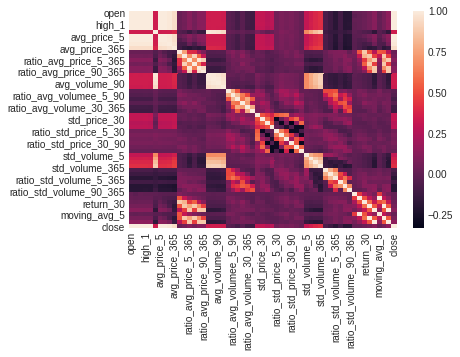

In [14]:
sns.heatmap(data.corr())

### SEGREGATING TRAIN AND TEST DATA

In [15]:
#import datetime module
import datetime

#segregate data for training
start_train = datetime.datetime(1999, 1, 1,0,0)
end_train = datetime.datetime(2017, 12, 31, 0, 0)
data_train = data.loc[start_train:end_train]
data_train.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,ratio_avg_price_905_,ratio_avg_price_5_365,ratio_avg_price_30_90,ratio_avg_price_30_365,ratio_avg_price_90_365,avg_volume_5,avg_volume_30,avg_volume_90,avg_volume_365,ratio_avg_volume_5_30,ratio_avg_volumee_5_90,ratio_avg_volume_5_365,ratio_avg_volume_30_90,ratio_avg_volume_30_365,ratio_avg_volume_90_365,std_price_5,std_price_30,std_price_90,std_price_365,ratio_std_price_5_30,ratio_std_price_5_90,ratio_std_price_5_365,ratio_std_price_30_90,ratio_std_price_30_365,ratio_std_price_90_365,std_volume_5,std_volume_30,std_volume_90,std_volume_365,ratio_std_volume_5_30,ratio_std_volume_5_90,ratio_std_volume_5_365,ratio_std_volume_30_90,ratio_std_volume_30_365,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4.941000e+03,4.941000e+03,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000
mean,1.207845,1.207844,1.207882,1.213555,1.202155,40948.114379,1.207882,1.207862,1.207876,1.207394,1.000044,1.000171,1.001250,1.000037,1.001081,1.000759,40918.319924,40780.041191,40463.938837,38663.015890,1.011099,1.041951,1.205963,1.022836,1.170854,1.117929,0.006470,0.012814,0.022393,0.047303,0.555956,0.321877,0.148122,0.623705,0.293985,0.505162,4542.926708,6248.042201,7675.028014,9778.707858,0.787251,0.660916,0.520427,8.499911e-01,6.854620e-01,0.816631,0.000020,0.000097,0.000457,0.001223,0.005686,0.000021,0.000019,0.000022,1.207885
std,0.172721,0.172721,0.172677,0.173244,0.172127,40535.398337,0.172545,0.172101,0.170867,0.164983,0.012569,0.026763,0.057658,0.019465,0.054063,0.044576,39948.109411,39435.308073,39026.738219,37726.547635,0.163677,0.366153,0.999129,0.174191,0.670447,0.373853,0.003894,0.006756,0.011477,0.020875,0.295577,0.186868,0.084335,0.250443,0.139508,0.214244,6202.465616,7220.078631,7943.757005,9468.948639,0.420002,0.468872,0.469948,3.202786e-01,4.144352e-01,0.323131,0.006320,0.013728,0.028651,0.050264,0.101303,0.002745,0.000801,0.000400,0.172676
min,0.827200,0.827200,0.826700,0.832600,0.822700,1.000000,0.833560,0.849195,0.858429,0.883636,0.949875,0.894925,0.826901,0.931309,0.852838,0.883052,168.800000,179.904762,206.666667,190.730159,0.308371,0.345970,0.418912,0.546644,0.619589,0.691981,0.000365,0.003002,0.006381,0.015971,0.031109,0.021686,0.007469,0.117013,0.064991,0.133604,0.000000,0.003311,64.580532,186.622525,0.000000,0.000000,0.000000,2.071391e-07,1.251220e-07,0.197396,-0.026604,-0.065191,-0.147266,-0.200039,-0.241870,-0.013307,-0.003489,-0.001086,0.826700
25%,1.086760,1.086760,1.086720,1.091700,1.080950,9051.000000,1.086860,1.086086,1.093687,1.102289,0.991980,0.982476,0.956647,0.986492,0.959101,0.966002,9050.400000,9040.095238,9071.095238,8945.166667,0.950242,0.929448,0.893880,0.952380,0.909005,0.924305,0.003785,0.008415,0.014517,0.031370,0.334962,0.184184,0.088755,0.432417,0.192123,0.340213,503.369347,702.308594,884.735550,1291.370850,0.469168,0.346896,0.252775,6.379958e-01,4.025237e-01,0.575167,-0.003710,-0.008580,-0.017528,-0.033266,-0.071921,-0.001699,-0.000515,-0.000276,1.086720
50%,1.232600,1.232600,1.232320,1.238200,1.226040,13905.000000,1.232142,1.230429,1.237444,1.240565,1.000064,1.001180,1.007453,1.000682,1.007681,1.006557,13682.000000,13271.761905,13230.380952,10932.087302,1.001368,1.004517,1.032327,1.001405,1.030141,1.027439,0.005628,0.011372,0.019380,0.0459

In [16]:
#segregate data for validation
start_test = datetime.datetime(2018, 1, 1, 0, 0)
end_test = datetime.datetime(2019, 6, 7, 0, 0)
data_test = data.loc[start_test:end_test]
data_test.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,ratio_avg_price_905_,ratio_avg_price_5_365,ratio_avg_price_30_90,ratio_avg_price_30_365,ratio_avg_price_90_365,avg_volume_5,avg_volume_30,avg_volume_90,avg_volume_365,ratio_avg_volume_5_30,ratio_avg_volumee_5_90,ratio_avg_volume_5_365,ratio_avg_volume_30_90,ratio_avg_volume_30_365,ratio_avg_volume_90_365,std_price_5,std_price_30,std_price_90,std_price_365,ratio_std_price_5_30,ratio_std_price_5_90,ratio_std_price_5_365,ratio_std_price_30_90,ratio_std_price_30_365,ratio_std_price_90_365,std_volume_5,std_volume_30,std_volume_90,std_volume_365,ratio_std_volume_5_30,ratio_std_volume_5_90,ratio_std_volume_5_365,ratio_std_volume_30_90,ratio_std_volume_30_365,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000
mean,1.168335,1.168551,1.168404,1.172679,1.164774,85860.709055,1.168790,1.170189,1.173200,1.175544,0.998793,0.996236,0.994591,0.997405,0.995734,0.998183,86076.016791,86934.733888,88030.342202,94176.970161,0.988373,0.977635,0.904970,0.985270,0.914560,0.928420,0.004493,0.007760,0.013166,0.034938,0.641844,0.406201,0.133445,0.675926,0.229061,0.385768,11868.015924,14836.028080,19042.542858,24416.037848,0.822346,0.678377,0.483281,0.823017,0.608195,0.785246,-0.000176,-0.000785,-0.002987,-0.007239,0.014224,-0.000156,-0.000114,0.000052,1.168174
std,0.038680,0.038614,0.038646,0.039068,0.038099,28427.264667,0.038265,0.036942,0.033194,0.017669,0.007005,0.015896,0.039145,0.011528,0.036849,0.030485,25325.257054,22834.340185,18174.794771,6771.873736,0.120040,0.203985,0.227735,0.140025,0.196934,0.145145,0.002091,0.003494,0.006873,0.009082,0.296836,0.226364,0.064043,0.286032,0.096374,0.205507,6936.294137,5716.490049,5363.318265,1756.643190,0.437726,0.415915,0.282394,0.295385,0.239640,0.234142,0.004373,0.009027,0.016337,0.030892,0.086742,0.001806,0.000491,0.000332,0.038700
min,1.113220,1.113220,1.113130,1.116200,1.111050,698.000000,1.116498,1.122836,1.127743,1.131791,0.980278,0.958818,0.951931,0.972393,0.958439,0.965983,38445.800000,46228.190476,55696.301587,75754.640965,0.650007,0.560327,0.496184,0.695282,0.610236,0.735220,0.001020,0.002998,0.005511,0.017220,0.102330,0.070232,0.031783,0.247986,0.082951,0.152565,0.000000,683.554534,11209.957491,21197.313418,0.000000,0.000000,0.000000,0.023540,0.030068,0.430578,-0.019107,-0.022843,-0.046899,-0.067556,-0.094090,-0.004603,-0.001100,-0.000383,1.113130
25%,1.136580,1.136750,1.136570,1.140910,1.133530,64344.000000,1.136546,1.137379,1.139820,1.161746,0.994924,0.988730,0.969421,0.992249,0.972179,0.974901,67880.600000,71394.904762,75140.476190,94076.698964,0.917240,0.837960,0.747187,0.881679,0.767924,0.807359,0.002958,0.005275,0.007392,0.028970,0.412920,0.229843,0.088893,0.397357,0.157059,0.247724,7572.713827,10828.324151,14084.804763,22811.431190,0.528578,0.432423,0.306273,0.666748,0.441971,0.569664,-0.002896,-0.007221,-0.011647,-0.025809,-0.054522,-0.001444,-0.000410,-0.000213,1.136550
50%,1.158720,1.158740,1.159300,1.162750,1.154300,79792.000000,1.161040,1.162870,1.162962,1.181830,0.999062,0.995503,0.976496,0.996417,0.977435,0.982091,79739.600000,79377.952381,83083.923841,96578.271667,1.001123,0.960873,0.840478,0.975436,0.834447,0.859325,0.004178,0.006529,0.010582,0.033038,0.610560,0.347427,0.122462,0.686323,0.204063,0.34

In [17]:
X_train = data_train.drop('close', axis='columns')
y_train = data_train.close

X_test = data_test.drop('close', axis='columns')
y_test = data_test.close

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4941, 54), (349, 54), (4941,), (349,))

### SCALING THE PREDICTOR DATA

In [18]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

### LINEAR REGRESSION (LIN)

In [19]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

RMSE: 0.005
MAE: 0.004
R^2: 0.983


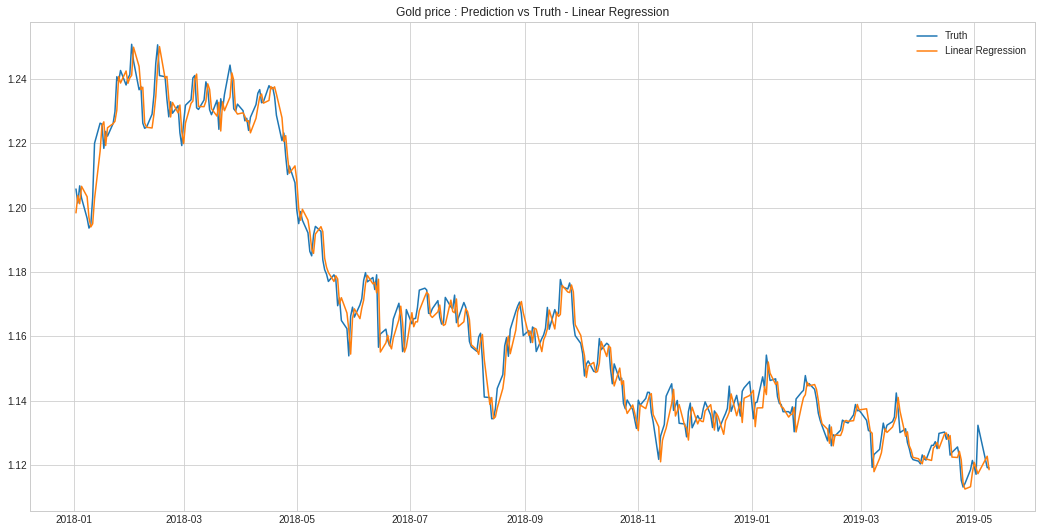

In [20]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plt.style.use('seaborn-whitegrid')
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title('Gold price : Prediction vs Truth - Linear Regression')
plt.show()

### SGD REGRESSOR (SGD)

In [21]:
# First experiment with linear regression

# SGD is very sensitive to data with features at different scales. Hence we need to do feature scaling before training.
#search for the SGD-based linear regression with the optimal set of parameters. 
from sklearn.linear_model import SGDRegressor

param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
}

sgd = SGDRegressor()
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

sgd_best = grid_search.best_estimator_
#print(grid_search.best_score_)

predictions_sgd = sgd_best.predict(X_scaled_test)

#evaluating the predictions
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_sgd)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_sgd)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_sgd)))

{'alpha': 0.0001, 'eta0': 0.03, 'penalty': 'l1'}
RMSE: 0.027
MAE: 0.021
R^2: 0.498


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


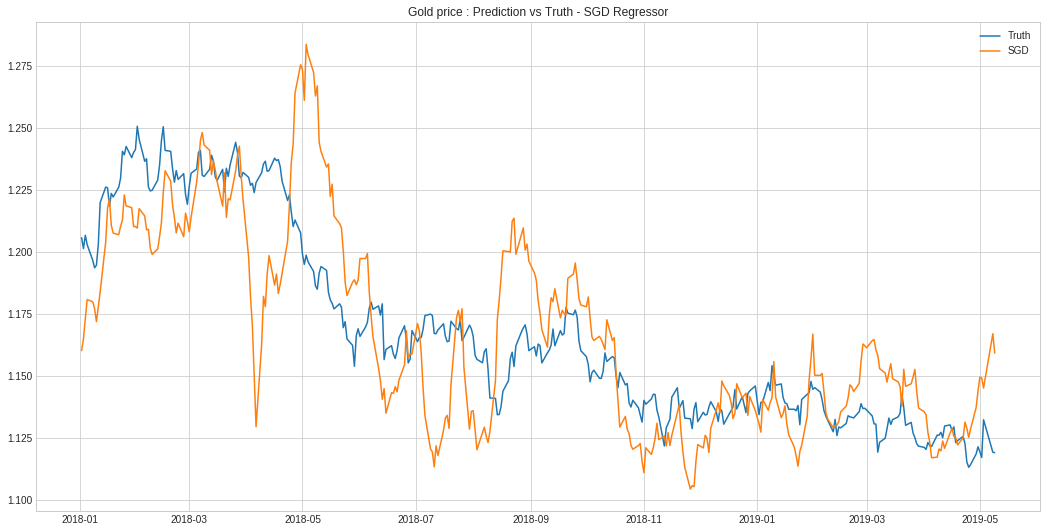

In [22]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_sgd, = plt.plot(dates, predictions_sgd)
plt.legend([plot_truth, plot_sgd], ['Truth', 'SGD'])
plt.title('Gold price : Prediction vs Truth - SGD Regressor')
plt.style.use('seaborn-whitegrid')
plt.show()

### Extreme Gradient Boosting Regressor (XGB)

In [23]:
xgb = XGBRegressor()

data_dmatrix = DMatrix(data=X_train,
                           label=y_train)

xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
                  'n_estimators': [50, 100, 200, 300],
                  'subsample': [0.3, 0.5, 0.7, 1]}

grid_search = GridSearchCV(estimator=xgb,    
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                       n_jobs=-1)

grid_search.fit(X_train, y_train) 

print("Best parameters found: ",grid_search.best_params_)

xgb_best = grid_search.best_estimator_

xgb_best.fit(X_train,y_train)
predictions_xgb = xgb_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_xgb)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_xgb)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_xgb)))

Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  5.7min finished


Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 50, 'subsample': 1}
RMSE: 0.006
MAE: 0.005
R^2: 0.973


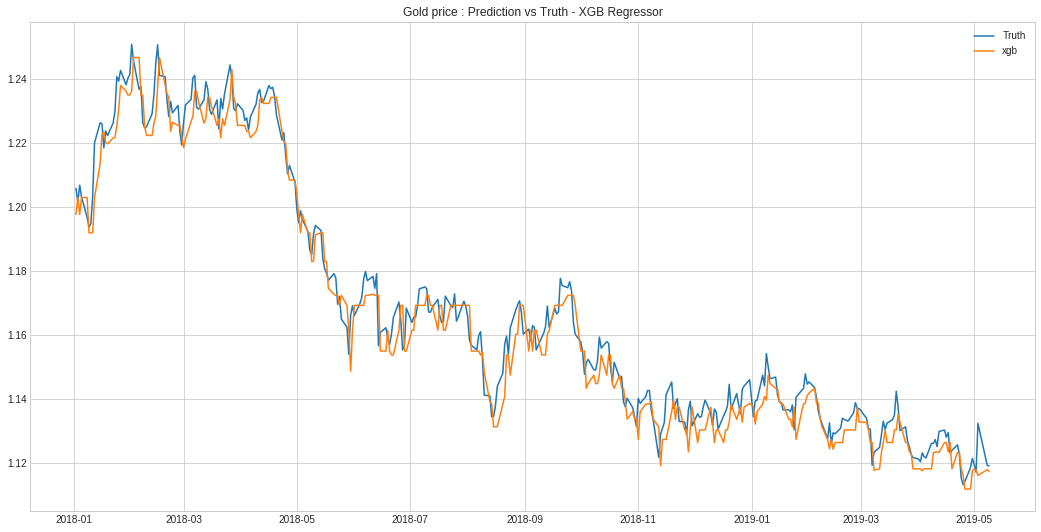

In [24]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_xgb, = plt.plot(dates, predictions_xgb)
plt.legend([plot_truth, plot_xgb], ['Truth', 'xgb'])
plt.title('Gold price : Prediction vs Truth - XGB Regressor')
plt.show()

### Bagging Regressor (BGR)

In [25]:
BaggingRegressor?

In [26]:
bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))

OOB: 1.000
RMSE: 0.005
MAE: 0.004
R^2: 0.983


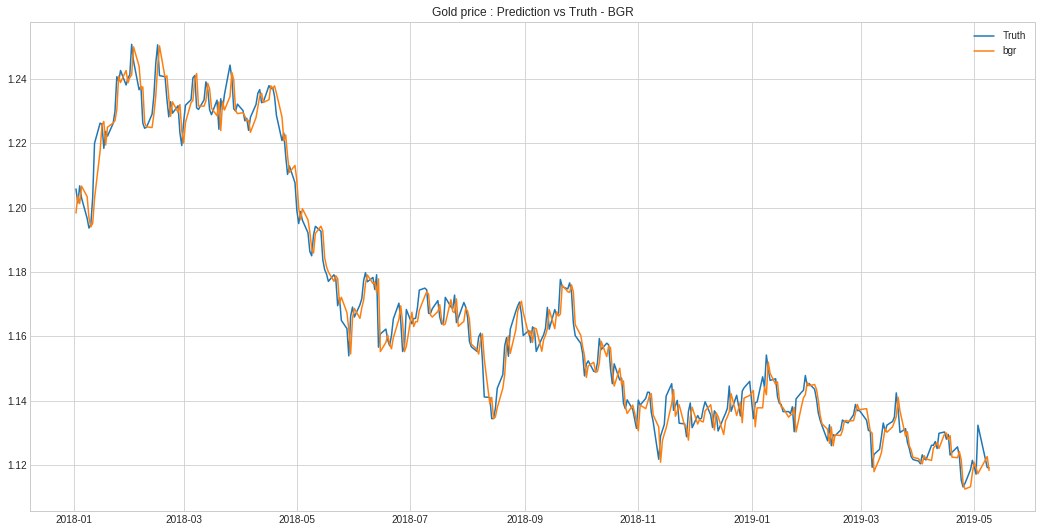

In [27]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_bgr, = plt.plot(dates, predictions_bgr)
plt.legend([plot_truth, plot_bgr], ['Truth', 'bgr'])
plt.title('Gold price : Prediction vs Truth - BGR')
plt.show()

### Random Forest Regressor (RF)

In [28]:
param_grid = {
    "max_depth": [30, 50],
    "min_samples_split": [5, 10, 20],

}

rf = RandomForestRegressor(n_estimators=100)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
# print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))


{'max_depth': 50, 'min_samples_split': 10}
RMSE: 0.006
MAE: 0.005
R^2: 0.977


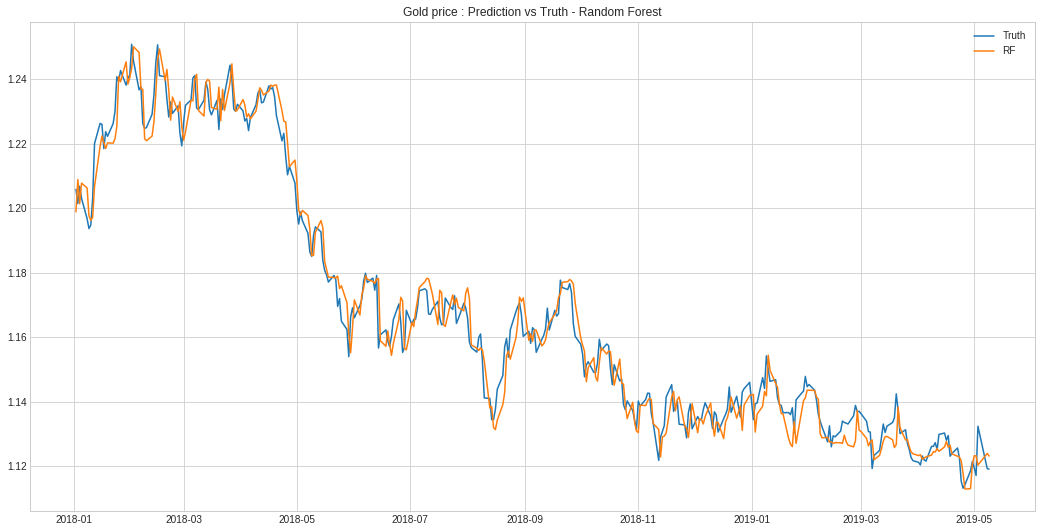

In [29]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_rf, = plt.plot(dates, predictions_rf)
plt.legend([plot_truth, plot_rf], ['Truth', 'RF'])
plt.title('Gold price : Prediction vs Truth - Random Forest')
plt.show()

The model with the least mean_absolute_error:
 LIN    0.004009
dtype: float64


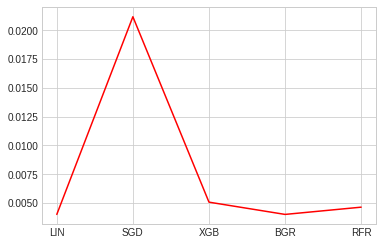

In [30]:
mae_scoring = pd.Series({'LIN':mean_absolute_error(y_test, predictions_lin),
                'SGD':mean_absolute_error(y_test, predictions_sgd),
                'XGB':mean_absolute_error(y_test, predictions_xgb),
                #'VTR':mean_absolute_error(y_test, predictions_vtr),
                'BGR':mean_absolute_error(y_test, predictions_bgr),
                'RFR':mean_absolute_error(y_test, predictions_rf)})

#filtering the regressor with the least mean_absolute_error value
filter = mae_scoring.min()
mae_min = mae_scoring[mae_scoring == mae_scoring.min()]
print('The model with the least mean_absolute_error:\n',mae_min)

plt.plot(mae_scoring, 'r')

### Saving, Loading and Predicting with the BGR Model

In [31]:
#saving the BGR model with sklearn:joblib
joblib.dump(bgr, 'bgr_eurusd_10062019.pkl')

['bgr_eurusd_10062019.pkl']

In [32]:
#loading the saved model
model = joblib.load('bgr_eurusd_10062019.pkl')

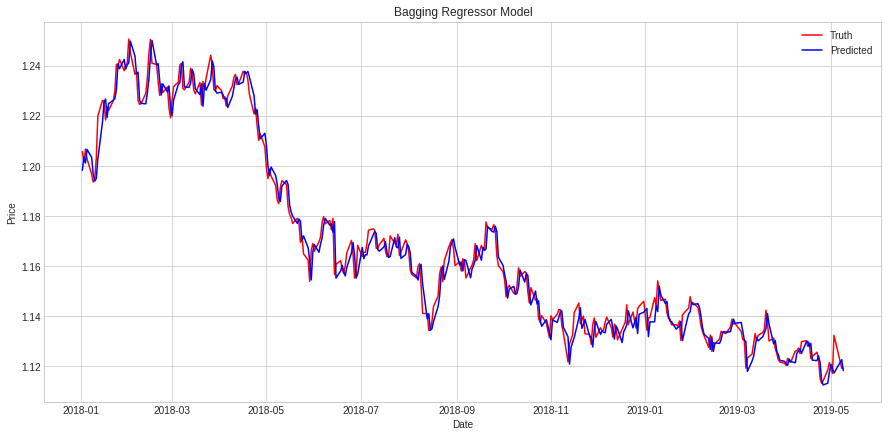

In [33]:
#Visualizing the predictions and truth values
pred = model.predict(X_scaled_test)
plt.figure(figsize=(15,7))
plt.plot(y_test, 'r', label='Truth')
plt.plot(y_test.index, pred, 'b', label='Predicted')
plt.title("Bagging Regressor Model")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

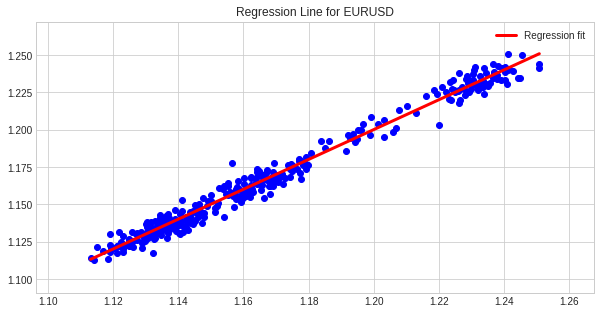

In [34]:
#plotting regression line
plt.style.use('seaborn-whitegrid')
plt.scatter(y_test, pred,color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=3, label='Regression fit')
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.title("Regression Line for EURUSD")
plt.legend()
plt.show()